In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import holidays
import pytz

from datetime import datetime
from scipy import stats
    
def plot_count(count, labels, title):
    pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_plot = plt.bar(pos,count,color='green',edgecolor='black')

    plt.title(title,fontsize=20, pad=20)
    plt.xticks(pos, labels, fontsize=15, rotation=0)
    plt.yticks(fontsize=15)
    plt.ylim(top=max(count)+0.1*max(count))
    
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                count[idx],
                ha='center', va='bottom', rotation=0, fontsize=15)
    
    plt.show()

In [2]:
drivers = pd.read_csv('data/drivers.csv')
pings = pd.read_csv('data/pings.csv')
train = pd.read_csv('data/train_80.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])

# Drivers 

In [7]:
drivers[pd.isnull(drivers).any(axis=1)]

,driver_id,gender,age,number_of_kids


In [4]:
drivers.head(2)

,driver_id,gender,age,number_of_kids
0,979863,MALE,26,2
1,780123,MALE,60,2


In [5]:
drivers.describe()

,driver_id,age,number_of_kids
count,2500.000000,2500.000000,2500.000000
mean,562397.047200,35.922400,1.395200
std,256410.208166,14.171207,1.505697
min,111556.000000,18.000000,0.000000
25%,343199.000000,25.000000,0.000000
50%,563854.500000,31.000000,1.000000
75%,787978.750000,45.000000,3.000000
max,998740.000000,75.000000,4.000000


### 1. Inconsistent driver information 

In [9]:
len(np.unique(drivers.driver_id))

2497

In [10]:
drivers = drivers.sort_values(by='driver_id')

In [11]:
drivers.groupby('driver_id').filter(lambda x: x['age'].count() > 1)

,driver_id,gender,age,number_of_kids
231,320227,MALE,22,4
388,320227,MALE,42,4
1765,799250,FEMALE,23,0
1311,799250,FEMALE,27,4
2008,800600,FEMALE,28,1
1550,800600,FEMALE,22,0


In [12]:
anomaly_driver_idx = [320227, 799250, 800600]
drivers2 = drivers[~drivers['driver_id'].isin(anomaly_driver_idx)].reset_index(drop=True)
train2 = train[~train['driver_id'].isin(anomaly_driver_idx)].reset_index(drop=True)
test2 = test[~test['driver_id'].isin(anomaly_driver_idx)].reset_index(drop=True)

#### a. male driver with 4 kids 

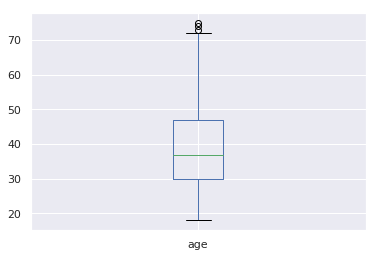

In [13]:
drivers[(drivers.gender == 'MALE')&(drivers.number_of_kids==4)][["age"]].boxplot()

#### b. female driver >< age  

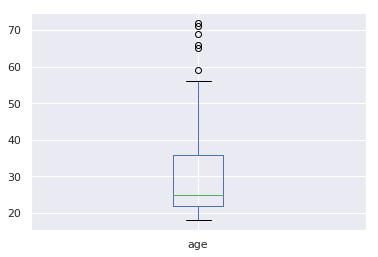

In [14]:
# TODO: boxplot
drivers[(drivers.gender == 'FEMALE')&(drivers.number_of_kids==0)][["age"]].boxplot()

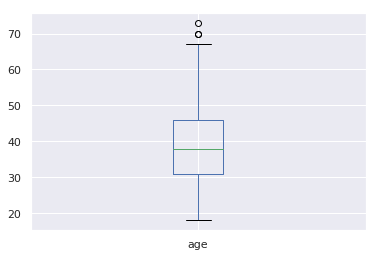

In [15]:
drivers[(drivers.gender == 'FEMALE')&(drivers.number_of_kids==1)][["age"]].boxplot()

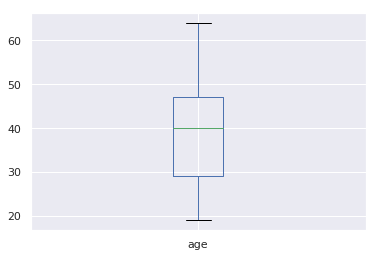

In [16]:
drivers[(drivers.gender == 'FEMALE')&(drivers.number_of_kids==4)][["age"]].boxplot()

#### c. female driver >< kids

In [17]:
# TODO: boxplot
drivers[(drivers.gender == 'FEMALE')&(drivers.age>20)&(drivers.age>29)]['number_of_kids'].describe()

count    358.000000
mean       1.807263
std        1.456850
min        0.000000
25%        0.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: number_of_kids, dtype: float64

### ============================================================ 

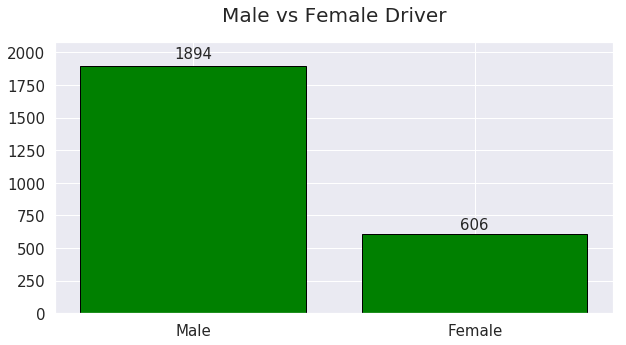

In [18]:
male = drivers.gender == 'MALE'
labels = ['Male', 'Female']
count = [len(drivers[male]), len(drivers[~male])]
plot_count(count, labels, title='Male vs Female Driver')

# Ping 

In [19]:
ping_by_timestamp = pings.groupby('ping_timestamp').agg({'driver_id':'count'}).reset_index()

In [20]:
min_timestamp = ping_by_timestamp.ping_timestamp.min()
cycle = 15

Text(0, 0.5, 'Number of Driver')

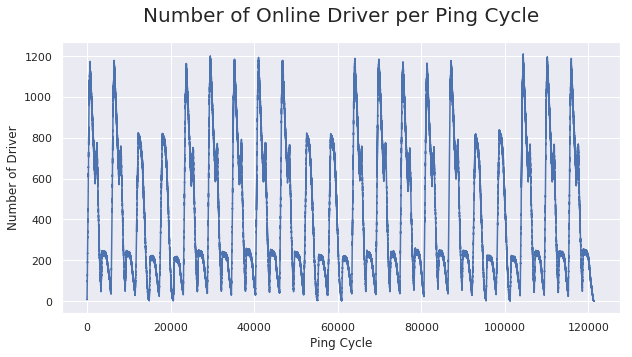

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot((ping_by_timestamp['ping_timestamp'] - min_timestamp)/cycle, 
         ping_by_timestamp['driver_id'])
plt.title('Number of Online Driver per Ping Cycle',fontsize=20, pad=20)
plt.xlabel('Ping Cycle')
plt.ylabel('Number of Driver')

In [22]:
one_day = 24*60*60/15

Text(0, 0.5, 'Number of Driver')

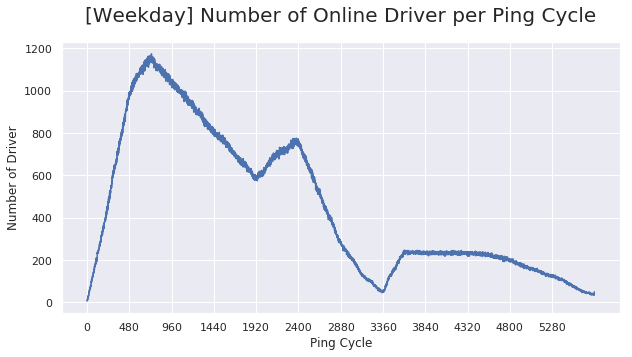

In [23]:
start = 0
end = start+one_day
fig, ax = plt.subplots(figsize=(10, 5))
plt.xticks(ticks=np.array(range(12))*(end//12))
plt.plot((ping_by_timestamp.loc[start:end]['ping_timestamp']-min_timestamp)/cycle,
         ping_by_timestamp.loc[start:end]['driver_id'])
plt.title('[Weekday] Number of Online Driver per Ping Cycle',fontsize=20, pad=20)
plt.xlabel('Ping Cycle')
plt.ylabel('Number of Driver')

Text(0, 0.5, 'Number of Driver')

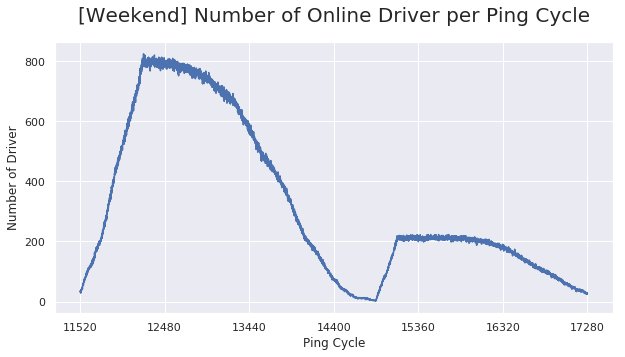

In [24]:
start = one_day*2
end = start+one_day
fig, ax = plt.subplots(figsize=(10, 5))
plt.xticks(ticks=start+np.array(range(12))*(start//12))
plt.plot((ping_by_timestamp.loc[start:end]['ping_timestamp']-min_timestamp)/cycle,
         ping_by_timestamp.loc[start:end]['driver_id'])
plt.title('[Weekend] Number of Online Driver per Ping Cycle',fontsize=20, pad=20)
plt.xlabel('Ping Cycle')
plt.ylabel('Number of Driver')

# Train 

In [25]:
print("number of known driver : ", len(train.driver_id.unique()))

number of known driver :  2480


In [26]:
train.head()

,driver_id,day,online_hours,date
0,111556,1,2.216667,2017-06-01
1,111556,2,2.500000,2017-06-02
2,111556,5,4.666667,2017-06-05
3,111556,6,3.116667,2017-06-06
4,111556,7,2.629167,2017-06-07


In [27]:
train.online_hours.describe()

count    41676.000000
mean         5.597530
std          2.818830
min          0.000000
25%          3.300000
50%          5.662500
75%          7.983333
max         11.916667
Name: online_hours, dtype: float64

In [28]:
train_merge = train

In [29]:
date = pd.date_range(start='6/1/2017', end='6/21/2017')
len_driver = len(train['driver_id'].unique())
len_date = len(date)

df = pd.DataFrame()
df['driver_id'] = np.tile(train['driver_id'].unique(), len_date)
df['date'] = date.repeat(len_driver)
df = df.sort_values(['driver_id', 'date'])

train_merge = pd.merge(df, train, on=['driver_id', 'date'], how='left')
train_merge.fillna(0, inplace=True)
    
train_merge['day'] = train_merge['date'].dt.day
train_merge['dayofweek'] = train_merge['date'].dt.dayofweek
train_merge['weekday'] = (train_merge['dayofweek'] < 5).astype(int)
train_merge['before_holiday'] = (train_merge['dayofweek'] == 4).astype(int)
train_merge['after_holiday'] = (train_merge['dayofweek'] == 0).astype(int)

train_merge['holiday'] = (train_merge['dayofweek'] > 4).astype(int)
national_holiday = (train_merge['day']==1)|(train_merge['day']>25)
train_merge.loc[national_holiday, 'holiday'] = 1

In [30]:
driver_group = train_merge.groupby('driver_id')['online_hours'].agg(['mean', 'std']).reset_index()

In [31]:
driver_group.describe()

,driver_id,mean,std
count,2480.000000,2480.000000,2480.000000
mean,561340.231452,4.477690,2.336092
std,256410.797475,2.352421,0.826433
min,111556.000000,0.923016,0.780505
25%,342533.000000,2.184623,1.715326
50%,563086.500000,4.157440,2.171039
75%,787411.000000,6.619692,2.812704
max,998229.000000,9.868651,5.264576


In [32]:
driver_group_2 = train_merge.groupby(['driver_id','holiday'])['online_hours'].agg(['mean', 'std'])

In [33]:
driver_group_2.describe()

,mean,std
count,4960.000000,4960.000000
mean,4.276370,1.956194
std,2.825216,1.032644
min,0.000000,0.000000
25%,2.071949,1.304188
50%,3.759524,1.663044
75%,6.942188,2.600765
max,10.120833,5.528135


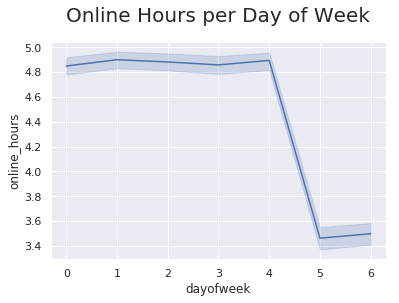

In [34]:
ax = sns.lineplot(x="dayofweek", y="online_hours", data=train_merge)
ax.set_title('Online Hours per Day of Week',fontsize=20, pad=20)
plt.show()

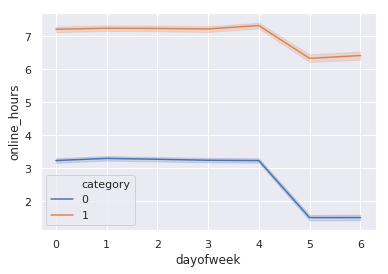

In [35]:
driver_0 = driver_group[driver_group['mean']<=5]['driver_id'].unique()
driver_1 = driver_group[driver_group['mean']>5]['driver_id'].unique()
train_merge['category'] = 0
train_merge.loc[train_merge['driver_id'].isin(driver_1), 'category'] = 1
ax = sns.lineplot(x="dayofweek", y="online_hours", hue='category', data=train_merge)

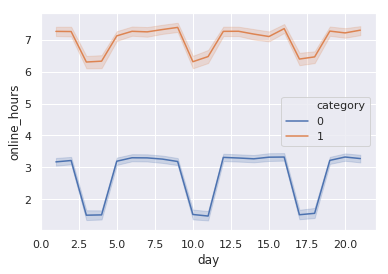

In [36]:
driver_0 = driver_group[driver_group['mean']<=5]['driver_id'].unique()
driver_1 = driver_group[driver_group['mean']>5]['driver_id'].unique()
train_merge['category'] = 0
train_merge.loc[train_merge['driver_id'].isin(driver_1), 'category'] = 1
ax = sns.lineplot(x="day", y="online_hours", hue='category', data=train_merge)

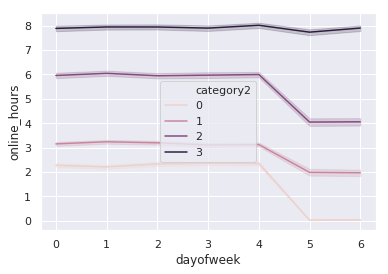

In [37]:
driver_0 = driver_group[driver_group['mean']<=2]['driver_id'].unique()
driver_1 = driver_group[(driver_group['mean']>2)&(driver_group['mean']<=4)]['driver_id'].unique()
driver_2 = driver_group[(driver_group['mean']>4)&(driver_group['mean']<=7)]['driver_id'].unique()
driver_3 = driver_group[driver_group['mean']>7]['driver_id'].unique()
train_merge['category2'] = 0
train_merge.loc[train_merge['driver_id'].isin(driver_1), 'category2'] = 1
train_merge.loc[train_merge['driver_id'].isin(driver_2), 'category2'] = 2
train_merge.loc[train_merge['driver_id'].isin(driver_3), 'category2'] = 3
ax = sns.lineplot(x="dayofweek", y="online_hours", hue='category2', data=train_merge)

# Test 

In [38]:
print("number of test driver : ", len(test.driver_id.unique()))

number of test driver :  2497


In [39]:
test.head(2)

,driver_id,date,online_hours
0,979863,2017-06-28,7
1,979863,2017-06-27,9


In [40]:
test.describe()

,driver_id,online_hours
count,17500.00000,17500.000000
mean,562397.04720,4.443829
std,256366.24585,3.382655
min,111556.00000,0.000000
25%,343199.00000,1.000000
50%,563854.50000,4.000000
75%,787978.75000,7.000000
max,998740.00000,11.000000


In [41]:
test_merge = pd.merge(test2, drivers2, on='driver_id', how='left', validate = 'm:1')

In [42]:
test_merge.tail(2)

,driver_id,date,online_hours,gender,age,number_of_kids
17456,165666,2017-06-23,6,MALE,35,1
17457,165666,2017-06-22,10,MALE,35,1


In [43]:
test_merge.describe()

,driver_id,online_hours,age,number_of_kids
count,17458.000000,17458.000000,17458.000000,17458.000000
mean,562210.290297,4.442433,35.943063,1.393344
std,256406.348340,3.383345,14.175419,1.503998
min,111556.000000,0.000000,18.000000,0.000000
25%,343259.000000,1.000000,25.000000,0.000000
50%,563744.500000,4.000000,31.000000,1.000000
75%,787522.000000,7.000000,45.000000,3.000000
max,998740.000000,11.000000,75.000000,4.000000


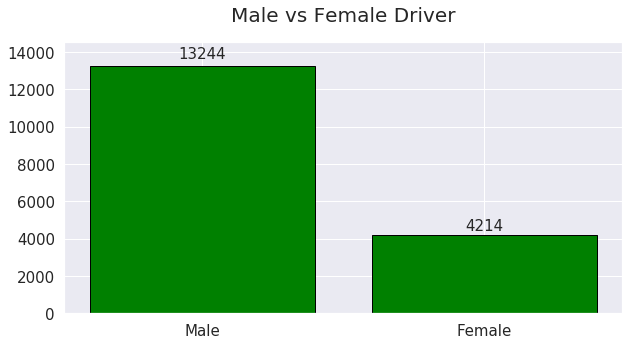

In [44]:
male = test_merge.gender == 'MALE'
labels = ['Male', 'Female']
count = [len(test_merge[male]), len(test_merge[~male])]
plot_count(count, labels, title='Male vs Female Driver')

In [45]:
test_merge = test_merge.sort_values(by='date')

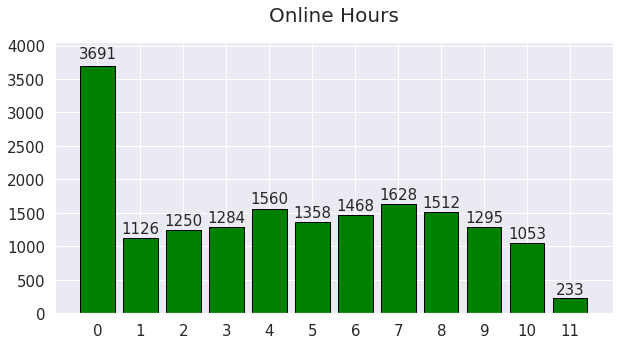

In [46]:
labels = np.sort(test_merge.online_hours.unique())
count = [len(test_merge[test_merge.online_hours == i]) for i in labels]
plot_count(count, labels, title='Online Hours')

In [47]:
test_merge['day'] = test_merge['date'].dt.day
test_merge['dayofweek'] = test_merge['date'].dt.dayofweek

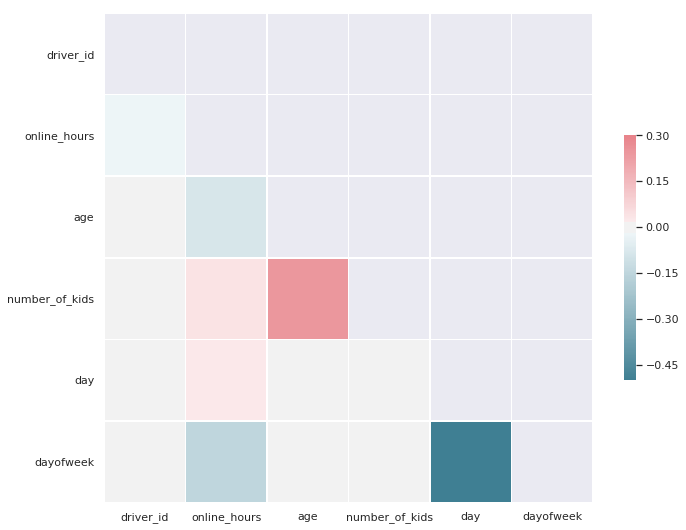

In [48]:
corr = test_merge.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

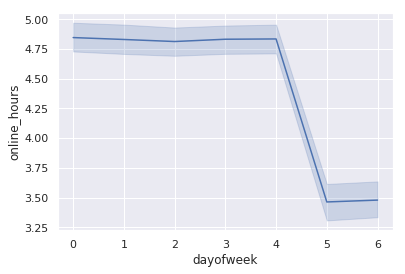

In [49]:
ax = sns.lineplot(x="dayofweek", y="online_hours", data=test_merge)

# Train & Test 

In [50]:
combined = pd.concat([train_merge[['driver_id', 'date', 'day', 'online_hours']],
                      test_merge[['driver_id', 'date', 'day', 'online_hours']]])

combined = combined.sort_values(by='date')

In [51]:
combined.head()

,driver_id,date,day,online_hours
0,111556,2017-06-01,1,2.216667
2604,162852,2017-06-01,1,0.000000
17031,402198,2017-06-01,1,7.233333
42357,844227,2017-06-01,1,0.000000
17010,401957,2017-06-01,1,0.000000


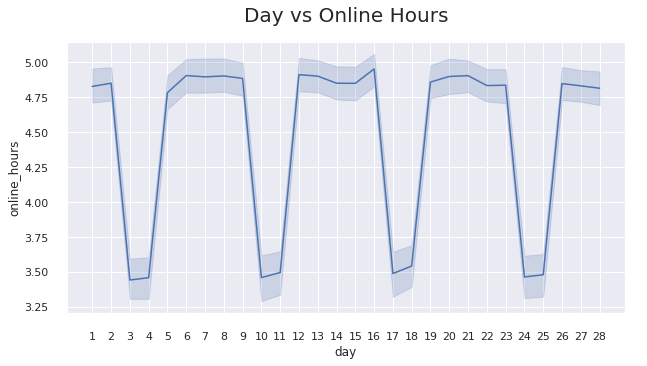

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="day", y="online_hours", data=combined)
ax.set(xticks=np.sort(combined['day'].unique()))
ax.set_title('Day vs Online Hours',fontsize=20, pad=20)
ax.tick_params(size=15)
plt.show()

In [53]:
combined['day'] = combined['date'].dt.day

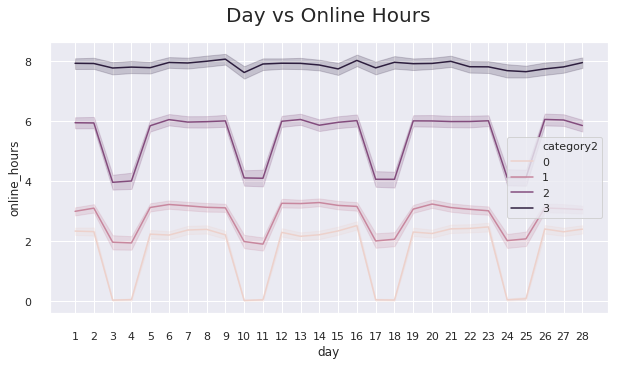

In [54]:
driver_0 = driver_group[driver_group['mean']<=2]['driver_id'].unique()
driver_1 = driver_group[(driver_group['mean']>2)&(driver_group['mean']<=4)]['driver_id'].unique()
driver_2 = driver_group[(driver_group['mean']>4)&(driver_group['mean']<=7)]['driver_id'].unique()
driver_3 = driver_group[driver_group['mean']>7]['driver_id'].unique()
combined['category2'] = 0
combined.loc[combined['driver_id'].isin(driver_1), 'category2'] = 1
combined.loc[combined['driver_id'].isin(driver_2), 'category2'] = 2
combined.loc[combined['driver_id'].isin(driver_3), 'category2'] = 3

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="day", y="online_hours", hue='category2', data=combined, ax=ax)
ax.set(xticks=np.sort(combined['day'].unique()))
ax.set_title('Day vs Online Hours',fontsize=20, pad=20)
ax.tick_params(size=15)
plt.show()

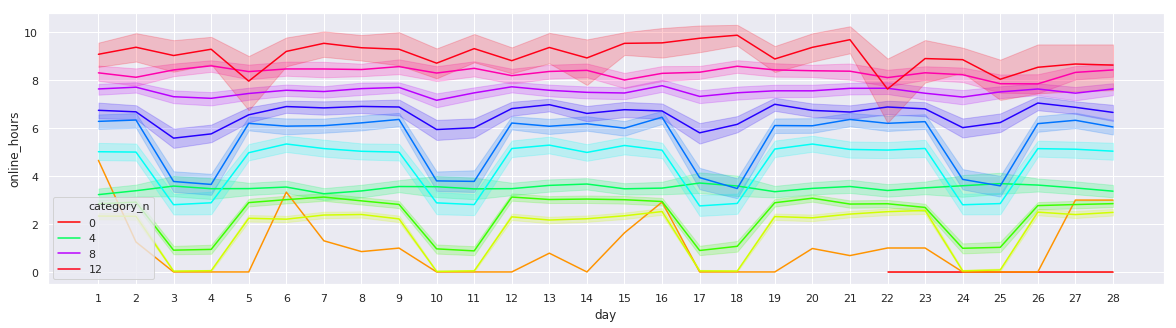

In [55]:
n=12
driver_i = {}
for i in range(n):
    driver_i[i] = driver_group[(driver_group['mean']>(i-1))&(driver_group['mean']<=i)]['driver_id'].unique()
    
combined['category_n'] = 0
for i in range(1, n):
    combined.loc[combined['driver_id'].isin(driver_i[i]), 'category_n'] = i

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="day", y="online_hours", hue='category_n', data=combined, palette='hsv', ax=ax)
ax.set(xticks=np.sort(combined['day'].unique()))
plt.show()